In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

In [3]:
path = Path('/root/.fastai/meggitt')

In [4]:
path

PosixPath('/root/.fastai/meggitt')

In [5]:
df = pd.read_csv(path/'meggitt_sales_unique_avg_2.csv', sep=',')

In [6]:
df.columns = ['source_system', 'finance_year', 'finance_month', 'customer', 'customer_division', 'partnumber', 
              'selling_site', 'type_of_sales', 'pipeline_category', 'price']

In [7]:
df.head(7)

,source_system,finance_year,finance_month,customer,customer_division,partnumber,selling_site,type_of_sales,pipeline_category,price
0,JDE_VC,2017,1,118429JDE_VC,Military,855612-115,MAS VC,MRO,Unknown,39445.042
1,JDE_VC,2017,1,118429JDE_VC,Military,9020-011-310F-16,MAS VC,MRO,Unknown,991.900
2,JDE_VC,2017,1,126819JDE_VC,Civil,MM-00150-12-40,MAS VC,MRO,Unknown,36313.797
3,JDE_VC,2017,1,527646JDE_VC,Civil,71133,MAS VC,MRO,Unknown,6340.880
4,JDE_VC,2017,1,641894JDE_VC,Civil,MM-00150-12-40,MAS VC,MRO,Unknown,36313.797
5,JDE_VC,2017,1,65073JDE_VC,Military,8941-01,MAS VC,MRO,Unknown,4293.900
6,JDE_VC,2017,1,65073JDE_VC,Military,904450-01,MAS VC,MRO,Unknown,5888.259


In [8]:
df.shape

(139665, 10)

In [9]:
df.price.std(), df.price.mean(), df.price.std() * 3

(1295311.7548101593, 10653.958696775051, 3885935.264430478)

In [10]:
df = df[np.abs(df.price-df.price.mean()) <= (3*df.price.std())]

In [11]:
df.shape

(139664, 10)

In [12]:
df = df[df.type_of_sales != 'XXXStretch']

In [13]:
df.shape

(139664, 10)

In [14]:
df = df[df.customer_division != 'Unknown']

In [15]:
df.shape

(139645, 10)

In [16]:
df = df[df.type_of_sales == 'Spares']

In [17]:
df.shape

(91600, 10)

In [18]:
df = df[df.price > 0.0]

In [19]:
df.shape

(91600, 10)

In [20]:
df.head(7)

,source_system,finance_year,finance_month,customer,customer_division,partnumber,selling_site,type_of_sales,pipeline_category,price
7,JDE_VC,2017,1,65346JDE_VC,Civil,902020-01,MAS VC,Spares,Unknown,598.0
8,JDE_VC,2017,1,65346JDE_VC,Civil,906607-03,MAS VC,Spares,Unknown,1638.0
9,JDE_VC,2017,1,65346JDE_VC,Civil,910061-01,MAS VC,Spares,Unknown,1326.0
48,JDE_VC,2017,2,66140JDE_VC,Civil,904656-10,MAS VC,Spares,Unknown,4165.2
50,JDE_VC,2017,2,66140JDE_VC,Civil,907822-02,MAS VC,Spares,Unknown,4745.0
55,JDE_VC,2017,2,72814JDE_VC,Civil,904800-01,MAS VC,Spares,Unknown,2347.8
56,JDE_VC,2017,2,737342JDE_VC,Civil,907801-04-03,MAS VC,Spares,Unknown,1549.6


In [21]:
dep_var = 'price'
cat_names = ['source_system', 'customer', 'customer_division', 'partnumber', 'selling_site', 'type_of_sales', 
             'pipeline_category', 'finance_year', 'finance_month']
cont_names = []
procs = [FillMissing, Categorify, Normalize]

In [22]:
range_start = 10000
range_end = int(10000 + df.shape[0] * 0.05)

In [23]:
range_start, range_end

(10000, 14580)

In [24]:
test = TabularList.from_df(df.iloc[range_start:range_end].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [25]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(range_start,range_end)))
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                           .add_test(test)
                           .databunch())

In [26]:
data.show_batch(rows=7)

source_system,customer,customer_division,partnumber,selling_site,type_of_sales,pipeline_category,finance_year,finance_month,target
QTM_UK,LUF002$QTM_UK,Civil,324200-2,CSS UK,Spares,Unknown,2019,6,8.2815075
QTM_US,100123QTM_US,Civil,19915909-3,CSS Miami,Spares,Unknown,2018,5,7.662863
MSAPXX,63566MSAPXX,Civil,7371342-114-1,NASCO,Spares,Unknown,2018,9,9.302628
SAP_SG,3598SAP_SG,Civil,30900000M,CSS Singapore,Spares,Base,2018,8,5.720843
MSAPXX,6393MSAPXX,Civil,727601,MPC Loughborough,Spares,Base,2018,6,6.433358
QTM_US,S112862QTM_US,Civil,7107,CSS Miami,Spares,Unknown,2018,2,6.9253435
QTM_US,C7111QTM_US,Civil,52001296-1,CSS Miami,Spares,Unknown,2018,11,8.238843


In [27]:
max_y = np.log(np.max(df[dep_var])*1.1)
y_range = torch.tensor([0, max_y], device=defaults.device)

In [28]:
max_y, y_range

(14.411275741668367, tensor([ 0.0000, 14.4113], device='cuda:0'))

In [29]:
learn = tabular_learner(data, layers=[500, 250], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=root_mean_squared_error)

In [30]:
learn.lr_find(num_it=300)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


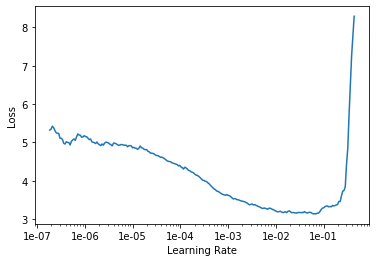

In [31]:
learn.recorder.plot()

In [32]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(8, 5)
    (1): Embedding(2559, 130)
    (2): Embedding(7, 5)
    (3): Embedding(10876, 291)
    (4): Embedding(18, 8)
    (5): Embedding(2, 2)
    (6): Embedding(5, 4)
    (7): Embedding(4, 3)
    (8): Embedding(13, 7)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=455, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=250, out_features=1, bias=True)
  )
)

In [33]:
def root_mean_squared_error_gil(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Root mean squared error between `pred` and `targ`."
    pred,targ = flatten_check(pred,targ)
    return torch.sqrt(F.mse_loss(pred, targ))

def mean_squared_error_fraction(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Mean squared error of the error percentage"
    pred,targ = flatten_check(pred,targ)
    return torch.mean(pred/targ)

In [34]:
pred = tensor([223.0, 123.0]).cuda()
targ = tensor([123.0, 123.0]).cuda()
print(mean_squared_error_fraction(pred, targ))
print(root_mean_squared_error_gil(pred, targ))

tensor(1.4065, device='cuda:0')
tensor(70.7107, device='cuda:0')


architecture [500, 250]
learning rate 0.003
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.194568,1.159939,1.053817,899.490784,00:09
1,1.005056,0.976987,0.963125,453.232635,00:09
2,0.963514,0.987317,0.969183,352.847534,00:09
3,0.945274,0.933227,0.940189,589.398926,00:09
4,0.867409,0.956888,0.955877,451.402588,00:09
5,0.837942,0.937947,0.944550,524.992798,00:09
6,0.735077,0.875315,0.912061,491.422119,00:09
7,0.724961,0.853742,0.895466,425.418427,00:09
8,0.576283,0.799409,0.867325,447.267822,00:09
9,0.490165,0.757320,0.840984,564.222351,00:10


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.440314,0.799566,0.867554,329.473846,00:10
1,0.740925,1.039302,0.995813,330.025848,00:09
2,0.938185,1.103903,1.026093,302.300568,00:09
3,1.013270,1.066266,1.009499,436.317291,00:09
4,0.987538,1.069203,1.005994,495.306122,00:09
5,0.916167,0.989661,0.972856,650.582397,00:09
6,0.819438,0.945061,0.950375,489.203827,00:09
7,0.756412,0.875171,0.909511,660.354004,00:09
8,0.684372,0.837798,0.887556,616.498047,00:09
9,0.568483,0.782252,0.856204,390.334381,00:09


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.196682,1.193206,1.073433,531.689392,00:09
1,0.998093,1.037886,0.998405,1004.116150,00:09
2,0.916593,1.018784,0.990390,392.053650,00:09
3,0.917656,1.070670,1.013803,591.898315,00:09
4,0.901726,1.012035,0.981271,677.246948,00:09
5,0.789864,0.951038,0.950726,606.013855,00:09
6,0.823007,0.950890,0.950369,562.205444,00:09
7,0.639810,0.852665,0.898836,384.366241,00:09
8,0.631459,0.851590,0.894715,423.708313,00:09
9,0.533553,0.793122,0.861745,486.132202,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.466157,0.795657,0.865018,414.224365,00:09
1,0.775669,1.029663,0.990395,718.073608,00:09
2,1.054921,1.122721,1.033947,671.814941,00:09
3,1.000116,1.003006,0.979917,843.565674,00:09
4,0.965837,1.006544,0.976632,652.438904,00:09
5,0.926839,1.072047,1.013069,713.070068,00:09
6,0.839257,0.977449,0.963636,722.595154,00:09
7,0.791938,0.929815,0.936961,521.440063,00:09
8,0.651557,0.835545,0.886575,468.229248,00:10
9,0.553710,0.802528,0.868649,453.089294,00:10


learning rate 0.001
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.164956,1.114289,1.033739,1247.707642,00:09
1,1.046528,0.993367,0.975961,670.062988,00:09
2,0.959865,1.010336,0.979170,382.367188,00:10
3,0.827566,0.932309,0.941643,482.428711,00:09
4,0.745049,0.841078,0.889095,306.675232,00:09
5,0.586538,0.825592,0.880550,690.167175,00:09
6,0.548322,0.802012,0.867084,510.802338,00:09
7,0.474126,0.778860,0.853015,509.004974,00:09
8,0.427732,0.767756,0.845432,461.148468,00:09
9,0.354889,0.756793,0.841139,419.402740,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.335489,0.764343,0.846289,438.394257,00:09
1,0.446507,0.840244,0.891261,510.098907,00:09
2,0.702987,0.954782,0.951228,397.248108,00:09
3,0.644858,0.907007,0.925033,501.855408,00:09
4,0.639720,0.915107,0.925664,651.754395,00:09
5,0.649390,0.845895,0.892521,338.961273,00:09
6,0.576749,0.890977,0.905773,468.784119,00:09
7,0.498285,0.829332,0.882390,361.681061,00:09
8,0.483536,0.819030,0.874435,478.178558,00:09
9,0.371137,0.809571,0.868848,504.279633,00:09


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.240077,1.185612,1.065450,640.237122,00:10
1,1.063877,1.012574,0.989977,207.778976,00:09
2,0.888251,0.948435,0.947340,812.885071,00:09
3,0.749175,0.904552,0.924630,568.676270,00:09
4,0.708257,0.863009,0.903340,637.556396,00:09
5,0.621844,0.821101,0.876455,468.126953,00:09
6,0.554095,0.824256,0.881178,454.046936,00:09
7,0.516544,0.795782,0.863635,344.495392,00:09
8,0.477643,0.773903,0.851214,328.907349,00:09
9,0.379221,0.778400,0.855363,399.051270,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.349594,0.786013,0.860694,354.058319,00:09
1,0.439943,0.827635,0.883904,433.178436,00:09
2,0.636713,0.885058,0.912101,344.377991,00:09
3,0.706683,0.946482,0.949084,418.186859,00:09
4,0.672741,0.929370,0.935916,509.713654,00:09
5,0.685401,0.861088,0.900408,596.145691,00:09
6,0.607504,0.856013,0.896207,408.552185,00:09
7,0.505341,0.815192,0.875586,366.664551,00:09
8,0.446209,0.786396,0.859797,470.574677,00:09
9,0.378156,0.804230,0.869453,386.208557,00:09


learning rate 0.0001
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.818840,1.621989,1.248058,1070.140747,00:09
1,1.112747,1.023119,0.988358,870.567322,00:09
2,0.935884,0.960515,0.959015,527.639221,00:09
3,0.746041,0.911309,0.933390,455.831329,00:09
4,0.650357,0.840870,0.893820,485.382324,00:09
5,0.573557,0.823710,0.883762,323.180725,00:09
6,0.493262,0.802731,0.871287,467.624725,00:09
7,0.467377,0.782231,0.859013,375.146973,00:09
8,0.381893,0.783456,0.859794,389.098572,00:09
9,0.354316,0.791755,0.862274,333.214874,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.304731,0.775752,0.854049,416.475555,00:09
1,0.380075,0.810784,0.873610,273.616608,00:09
2,0.441256,0.847372,0.895152,434.396210,00:09
3,0.492176,0.828469,0.885256,328.810364,00:09
4,0.443812,0.830225,0.883800,297.255829,00:09
5,0.383188,0.843229,0.891962,491.855835,00:09
6,0.330942,0.814772,0.875737,256.276428,00:09
7,0.297925,0.817784,0.877328,227.856049,00:09
8,0.296521,0.823942,0.881254,298.453644,00:09
9,0.239913,0.809641,0.872598,232.347427,00:09


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.913946,1.666017,1.260985,434.629547,00:09
1,1.192316,1.059587,0.999431,367.944489,00:09
2,0.936937,0.952715,0.949352,380.394592,00:09
3,0.762080,0.906265,0.928182,389.235321,00:09
4,0.686108,0.858854,0.902242,327.442017,00:09
5,0.552382,0.821344,0.880318,337.072937,00:09
6,0.539409,0.803987,0.869080,406.474548,00:09
7,0.463024,0.783625,0.859692,358.779572,00:09
8,0.397719,0.784237,0.857112,357.125610,00:09
9,0.388548,0.782988,0.857028,323.440704,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.321636,0.781520,0.856984,289.966034,00:09
1,0.389745,0.820178,0.877572,321.118988,00:09
2,0.469333,0.818866,0.878458,265.311493,00:09
3,0.461685,0.834510,0.888971,289.382874,00:09
4,0.434612,0.828368,0.885914,429.907349,00:10
5,0.418855,0.802687,0.872743,330.516327,00:09
6,0.366813,0.818359,0.878851,498.662933,00:09
7,0.330483,0.802892,0.869850,358.000031,00:09
8,0.293241,0.788515,0.863511,300.229462,00:09
9,0.272593,0.800759,0.868766,438.990326,00:09


architecture [1000, 500]
learning rate 0.003
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.189251,1.270338,1.107492,568.135559,00:09
1,1.088856,0.985890,0.973472,401.114960,00:09
2,0.908499,0.992616,0.968258,614.268250,00:09
3,0.893452,1.045836,0.999996,1145.469482,00:09
4,0.842490,1.015392,0.983850,581.239746,00:09
5,0.863170,1.002822,0.975607,556.394653,00:10
6,0.818989,0.940324,0.948788,386.192719,00:10
7,0.674360,0.860125,0.899069,440.743683,00:09
8,0.599630,0.832713,0.884398,565.520813,00:09
9,0.493377,0.773423,0.850685,340.219696,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.430775,0.791568,0.861226,389.752533,00:09
1,0.741174,0.974323,0.962714,766.834839,00:09
2,1.020056,1.074948,1.012154,624.965210,00:09
3,1.065067,1.023980,0.984061,730.529724,00:09
4,1.021285,1.016833,0.985400,702.710144,00:09
5,0.934141,1.050283,1.003398,365.646576,00:09
6,0.842716,0.961974,0.958017,578.423767,00:09
7,0.717264,0.934500,0.940063,440.944885,00:09
8,0.645739,0.835038,0.889672,547.133606,00:09
9,0.547603,0.785729,0.858719,517.105713,00:09


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.229783,1.226626,1.091992,815.926758,00:09
1,1.045250,1.046948,1.001843,1004.851440,00:09
2,0.923904,1.049577,1.006039,570.623901,00:09
3,0.905950,1.044959,0.991175,558.780640,00:09
4,0.873216,1.053387,1.007316,538.889221,00:09
5,0.815103,0.931961,0.941614,533.581482,00:10
6,0.800236,0.899721,0.925702,652.313660,00:09
7,0.682909,0.932665,0.940367,392.833496,00:09
8,0.701522,0.803257,0.867629,400.442902,00:09
9,0.470916,0.761263,0.844165,414.375061,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.459395,0.810001,0.871609,311.874390,00:09
1,0.773317,0.996334,0.974711,372.306885,00:09
2,1.062710,1.061851,1.005391,467.055573,00:09
3,1.073787,0.978417,0.966348,450.923676,00:09
4,1.002101,0.973624,0.966258,256.516266,00:09
5,0.937587,1.080056,1.005306,791.127380,00:09
6,0.857547,0.955099,0.953685,505.662720,00:09
7,0.774775,0.911990,0.928564,497.054626,00:09
8,0.665727,0.825383,0.881518,574.406738,00:09
9,0.531304,0.766812,0.850347,486.149292,00:09


learning rate 0.001
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.270034,1.217422,1.083160,239.939240,00:09
1,1.082519,1.020317,0.989743,1084.072388,00:09
2,0.901836,0.934324,0.942459,380.348267,00:09
3,0.757709,0.876428,0.910131,503.958466,00:09
4,0.678702,0.827162,0.884304,390.497253,00:09
5,0.573004,0.895500,0.919374,505.011902,00:09
6,0.558617,0.807694,0.871281,417.458954,00:09
7,0.501601,0.802969,0.868411,386.744568,00:09
8,0.462140,0.796535,0.862351,445.474060,00:09
9,0.395626,0.777602,0.852181,420.989319,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.313271,0.797671,0.865160,382.206207,00:09
1,0.457832,0.827794,0.884169,477.249725,00:10
2,0.641454,0.920046,0.935618,403.367676,00:09
3,0.695803,0.899534,0.920712,469.970795,00:09
4,0.681735,0.895703,0.914914,505.968170,00:09
5,0.611278,0.923053,0.933217,404.492615,00:09
6,0.569445,0.824189,0.882874,413.618256,00:09
7,0.468483,0.839773,0.884973,329.541534,00:09
8,0.405709,0.820815,0.880779,392.715515,00:10
9,0.356109,0.785153,0.855232,483.407806,00:09


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.310228,1.254733,1.097024,508.115387,00:09
1,1.038001,1.012405,0.985659,188.130630,00:09
2,0.878884,0.967296,0.952195,429.278625,00:10
3,0.782282,0.883291,0.914485,498.779205,00:09
4,0.675506,0.910120,0.927246,515.188538,00:09
5,0.635930,0.845196,0.890790,374.143768,00:09
6,0.556915,0.840228,0.888609,552.882446,00:09
7,0.557369,0.814381,0.871725,432.777191,00:09
8,0.453688,0.810015,0.869825,532.810669,00:09
9,0.372798,0.785749,0.855972,452.019745,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.340669,0.802648,0.864834,368.533966,00:09
1,0.507641,0.854618,0.893187,504.371735,00:09
2,0.650923,0.936185,0.941359,366.397858,00:09
3,0.689460,0.969779,0.954217,629.225647,00:09
4,0.661466,0.878508,0.909618,500.940277,00:09
5,0.648923,0.896364,0.918735,254.356171,00:09
6,0.551314,0.907480,0.920539,572.316345,00:09
7,0.502437,0.812176,0.872552,530.647766,00:09
8,0.428350,0.809470,0.870113,329.843353,00:09
9,0.352947,0.811468,0.871974,404.125641,00:09


learning rate 0.0001
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.664740,1.466699,1.189386,1352.631226,00:09
1,1.045842,1.116911,1.035446,1320.026855,00:09
2,0.921803,0.963866,0.961140,894.390686,00:09
3,0.783001,0.941802,0.949196,250.983734,00:09
4,0.695425,0.847655,0.900176,235.176453,00:09
5,0.554366,0.825361,0.887017,297.739655,00:09
6,0.488197,0.803872,0.872925,337.631561,00:09
7,0.414562,0.782344,0.860982,215.851822,00:09
8,0.333597,0.809000,0.874502,280.189850,00:09
9,0.291310,0.789331,0.862295,219.391083,00:09


weight decay 0.3


/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py:560: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.265373,0.797635,0.867759,200.534225,00:09
1,0.333956,0.839694,0.892494,325.404022,00:09
2,0.420992,0.866257,0.907775,170.692078,00:09
3,0.414865,0.853038,0.898906,263.000641,00:09
4,0.385963,0.863623,0.904093,301.431641,00:09
5,0.358298,0.851891,0.900524,243.427887,00:09
6,0.308765,0.839789,0.892240,358.378326,00:09
7,0.310075,0.861914,0.905508,335.525146,00:09
8,0.235409,0.833916,0.887366,281.050476,00:09
9,0.197232,0.844054,0.892649,289.298157,00:09


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.739479,1.549847,1.220881,988.037231,00:09
1,1.164369,1.022063,0.987592,347.163391,00:09
2,0.964779,0.951035,0.955608,355.256042,00:09
3,0.745590,0.905877,0.926982,300.812073,00:09
4,0.658469,0.848229,0.898809,169.256912,00:09
5,0.576954,0.821833,0.882443,249.831299,00:10
6,0.520349,0.823893,0.881404,982.212463,00:09
7,0.463334,0.797181,0.867380,431.583435,00:09
8,0.385489,0.782514,0.855932,513.035889,00:09
9,0.371255,0.784954,0.858290,435.155701,00:09


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.320690,0.788644,0.859908,463.332031,00:10
1,0.423594,0.834409,0.887114,571.798645,00:09
2,0.443043,0.828672,0.883738,415.055176,00:09
3,0.491761,0.849835,0.894686,338.129456,00:09
4,0.436514,0.847543,0.896376,369.159760,00:09
5,0.391968,0.826346,0.881912,439.538635,00:09
6,0.328625,0.848946,0.892598,442.512299,00:09
7,0.333518,0.847411,0.893261,404.375549,00:09
8,0.281759,0.826980,0.880794,335.112976,00:09
9,0.243324,0.838556,0.888017,284.165771,00:09


architecture [2000, 1000]
learning rate 0.003
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.254134,1.246788,1.089233,326.909332,00:10
1,1.027935,1.030348,0.989879,457.449341,00:11
2,1.004051,1.015601,0.983024,595.115173,00:11
3,0.971860,0.947221,0.947065,843.450562,00:11
4,0.913612,0.986410,0.969913,244.588623,00:11
5,0.774906,0.946837,0.946847,460.988586,00:11
6,0.777932,0.881265,0.916906,351.065643,00:11
7,0.707550,0.914999,0.933271,321.024933,00:10
8,0.587174,0.819573,0.877087,331.332031,00:11
9,0.494334,0.796669,0.860404,393.335999,00:11


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.403714,0.809630,0.872014,384.687256,00:11
1,0.756184,1.008029,0.977549,321.675842,00:10
2,1.015971,1.016739,0.989228,601.419312,00:11
3,0.997208,1.030672,0.991698,368.162659,00:11
4,0.957956,0.989847,0.973550,310.550842,00:11
5,0.876272,0.987848,0.971262,874.980652,00:11
6,0.881007,0.947679,0.952970,612.612427,00:11
7,0.768351,0.919710,0.933965,562.994080,00:11
8,0.612946,0.819260,0.879677,429.880127,00:11
9,0.507480,0.774379,0.851531,401.320892,00:11


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.232092,1.166210,1.054328,806.195007,00:11
1,1.069020,1.106945,1.030200,355.785583,00:10
2,0.989362,0.950675,0.948550,740.578857,00:11
3,0.932719,1.040234,0.997917,306.527496,00:10
4,0.917497,0.905905,0.927962,611.382324,00:10
5,0.840559,0.947914,0.950148,875.246582,00:11
6,0.728518,0.917681,0.932641,663.904480,00:11
7,0.655026,0.849694,0.895904,520.620911,00:11
8,0.614665,0.807660,0.871420,543.905762,00:11
9,0.489216,0.794818,0.863309,434.602844,00:11


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.434556,0.790763,0.861048,318.197968,00:11
1,0.750287,1.015609,0.984395,863.612427,00:11
2,0.993082,1.069697,1.013519,320.796997,00:11
3,1.051482,1.069291,1.012362,546.507935,00:11
4,0.947115,1.070502,1.010803,474.366852,00:10
5,0.917966,1.098205,1.022169,360.976868,00:11
6,0.818283,0.998130,0.972940,701.314331,00:11
7,0.788102,0.861368,0.901960,416.845947,00:11
8,0.698449,0.839895,0.893075,531.033691,00:10
9,0.542124,0.778790,0.852851,536.996399,00:11


learning rate 0.001
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.248188,1.280826,1.112161,283.123993,00:10
1,1.077453,1.005675,0.979527,436.646301,00:11
2,0.863338,1.039715,0.991396,306.364563,00:11
3,0.745968,0.938554,0.943026,568.891479,00:11
4,0.675905,0.882346,0.913956,578.967712,00:11
5,0.597899,0.848390,0.892617,422.476379,00:11
6,0.538959,0.831208,0.887993,423.277985,00:10
7,0.481059,0.781736,0.857318,348.123352,00:11
8,0.440786,0.789222,0.860440,316.416962,00:11
9,0.402511,0.794314,0.862451,331.328857,00:11


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.312546,0.824050,0.880189,354.618866,00:11
1,0.486210,0.856661,0.896706,356.947113,00:10
2,0.620230,0.932520,0.937071,359.864136,00:11
3,0.695101,0.962957,0.956070,327.281982,00:11
4,0.635710,0.931210,0.938445,704.614807,00:11
5,0.627453,0.940447,0.941882,481.650970,00:11
6,0.537370,0.902095,0.923752,334.044647,00:11
7,0.528386,0.848197,0.894840,287.454437,00:11
8,0.388523,0.815526,0.875797,330.683044,00:11
9,0.368112,0.822560,0.879124,370.127960,00:11


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.353252,1.250154,1.094872,174.971405,00:11
1,1.129965,1.048730,1.004854,533.755920,00:11
2,0.926449,0.986553,0.969814,660.418640,00:11
3,0.837536,0.894871,0.923451,535.606873,00:11
4,0.654424,0.843938,0.891961,484.603485,00:11
5,0.630123,0.819880,0.877878,497.693604,00:11
6,0.567241,0.796782,0.866598,344.969910,00:11
7,0.506075,0.789752,0.860984,403.182678,00:11
8,0.476428,0.782840,0.853821,474.356262,00:11
9,0.377352,0.770647,0.849613,311.519104,00:10


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.342243,0.795181,0.862357,294.109589,00:11
1,0.517013,0.834220,0.887029,341.843140,00:11
2,0.631168,0.939532,0.942946,388.163605,00:11
3,0.736757,0.914512,0.929372,252.894623,00:11
4,0.668758,0.874882,0.908168,343.549805,00:10
5,0.618687,0.894187,0.919186,390.303467,00:11
6,0.566289,0.836085,0.884818,395.736145,00:10
7,0.513930,0.853304,0.895899,407.938080,00:11
8,0.440763,0.793004,0.861554,367.736084,00:11
9,0.385869,0.806731,0.870225,337.300507,00:11


learning rate 0.0001
embedding drop out 0.04
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.561566,1.397503,1.156778,724.524536,00:11
1,1.136093,1.145393,1.049393,369.522919,00:10
2,0.951762,0.954925,0.957359,649.927429,00:10
3,0.798059,0.934059,0.940298,983.010681,00:11
4,0.652527,0.882950,0.917163,628.507996,00:11
5,0.556302,0.895086,0.919235,674.843994,00:11
6,0.527481,0.827658,0.885317,371.296143,00:11
7,0.384344,0.802303,0.871281,373.837952,00:11
8,0.331759,0.800723,0.868373,371.974030,00:11
9,0.280029,0.813739,0.876854,340.762482,00:10


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.266668,0.830256,0.886941,298.136627,00:11
1,0.299276,0.880175,0.912881,285.654053,00:11
2,0.387864,0.858437,0.901736,315.527527,00:10
3,0.416567,0.863350,0.905873,252.691818,00:10
4,0.354072,0.904376,0.925023,277.516418,00:11
5,0.343647,0.866361,0.904539,226.306747,00:11
6,0.284408,0.859320,0.903438,327.183960,00:11
7,0.268740,0.874920,0.908753,315.715637,00:11
8,0.218390,0.858161,0.901437,218.111435,00:10
9,0.168858,0.882530,0.912879,242.614487,00:10


embedding drop out 0.1
weight decay 0.2


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.693849,1.420581,1.169290,141.501495,00:11
1,1.217024,1.102797,1.025715,603.878906,00:10
2,0.971741,1.017509,0.990557,328.301941,00:11
3,0.818281,0.912303,0.932463,431.533112,00:11
4,0.680912,0.894212,0.921637,511.933960,00:11
5,0.582070,0.819939,0.882608,453.435303,00:11
6,0.487663,0.819939,0.878292,742.398865,00:10
7,0.416114,0.815124,0.876704,366.616211,00:10
8,0.374920,0.783456,0.859058,462.524292,00:11
9,0.334591,0.805146,0.870545,352.652771,00:11


weight decay 0.3


epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,0.318550,0.814561,0.875660,358.331818,00:11
1,0.381308,0.836606,0.888901,262.993927,00:10
2,0.433595,0.875078,0.909761,327.718170,00:11
3,0.454092,0.867533,0.905542,324.971191,00:11
4,0.412466,0.842659,0.890961,291.724792,00:11
5,0.369708,0.841184,0.891766,238.880356,00:10
6,0.376844,0.888329,0.916502,352.839478,00:11
7,0.309095,0.853707,0.895768,242.775818,00:11
8,0.264873,0.852185,0.897742,248.315796,00:11
9,0.223559,0.834383,0.887162,239.787033,00:11


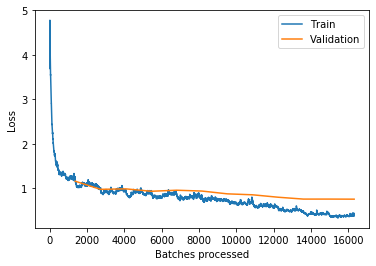

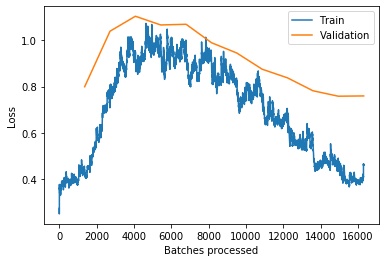

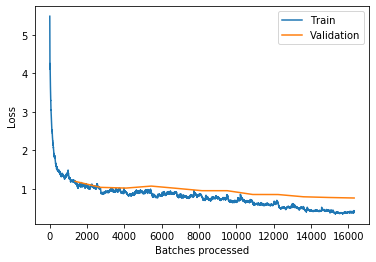

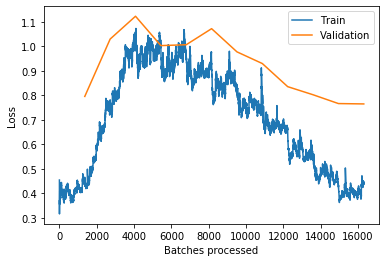

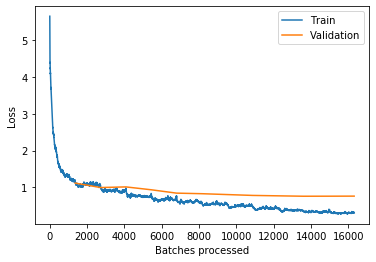

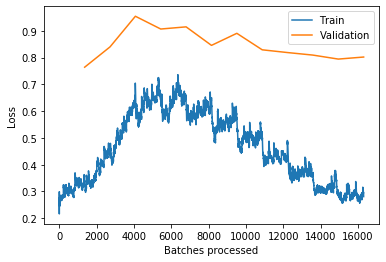

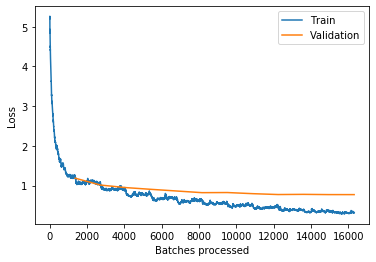

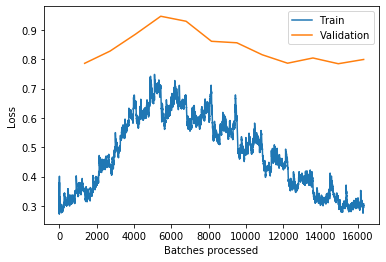

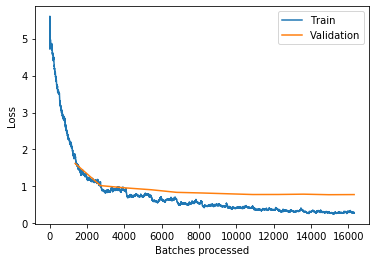

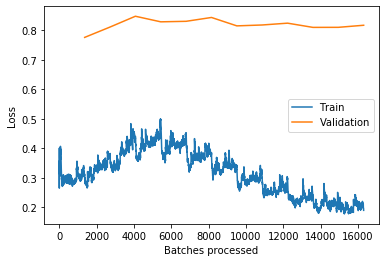

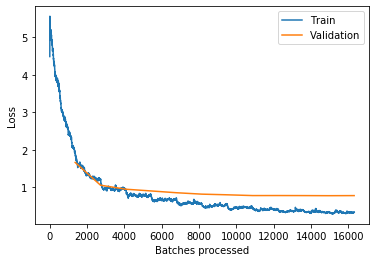

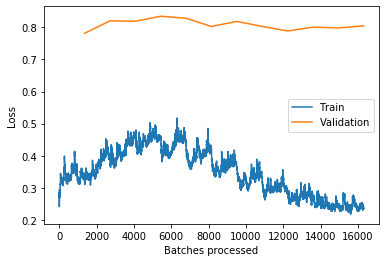

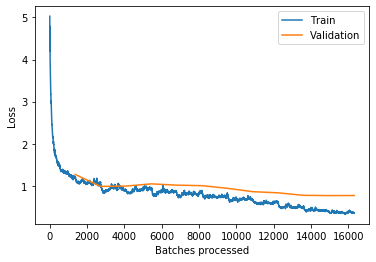

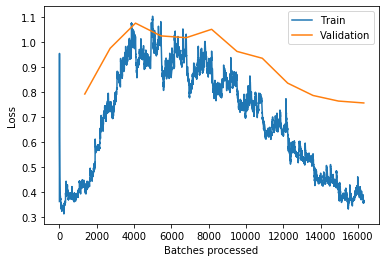

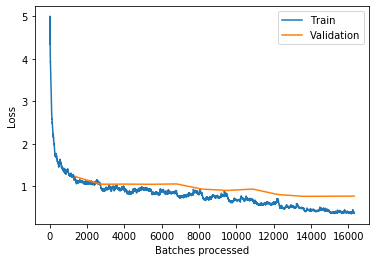

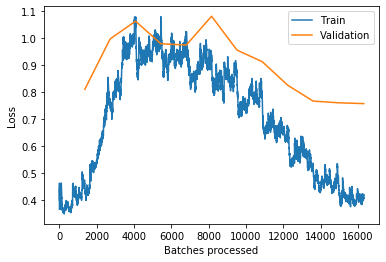

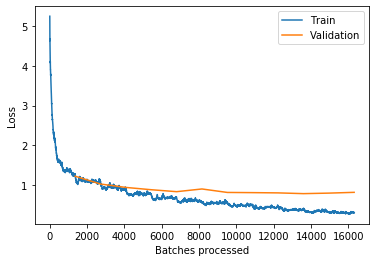

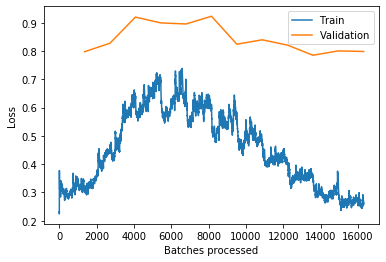

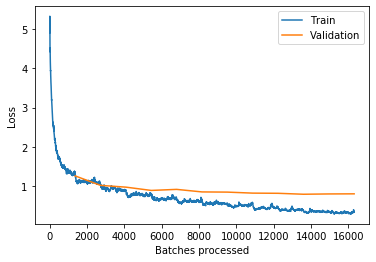

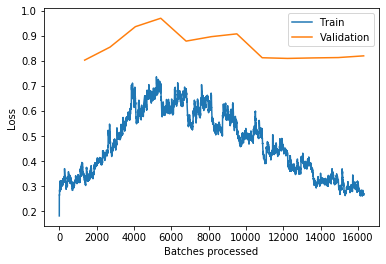

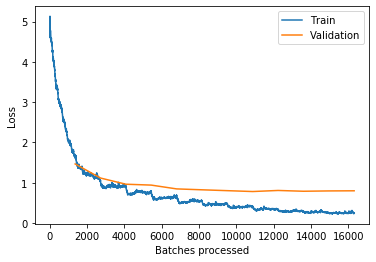

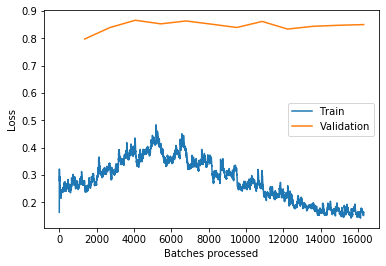

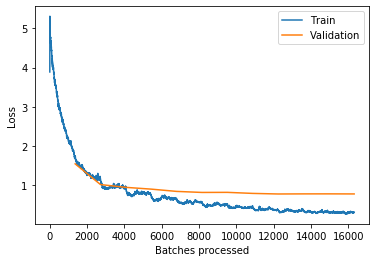

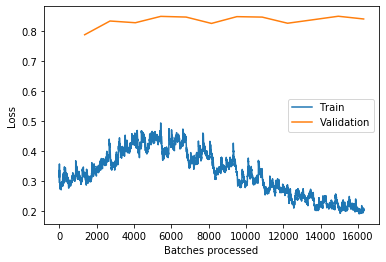

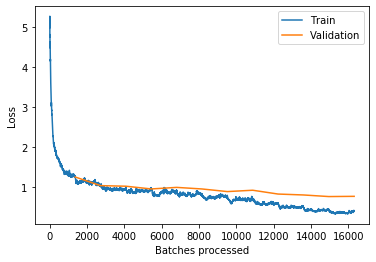

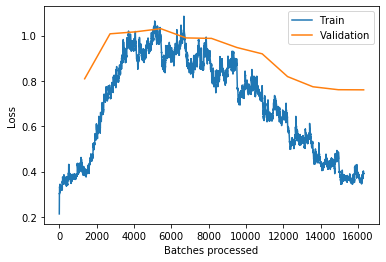

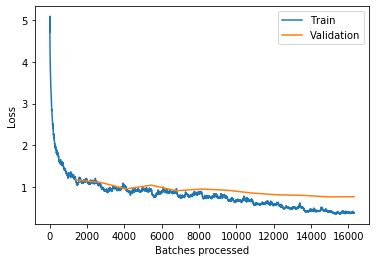

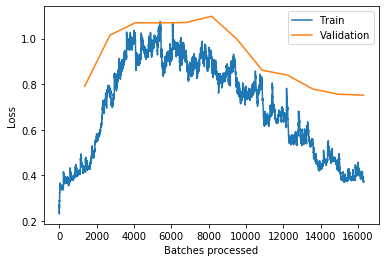

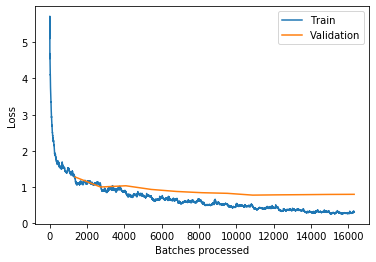

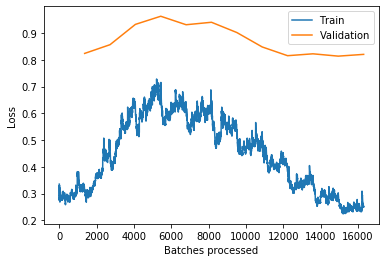

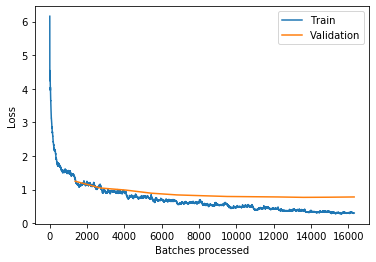

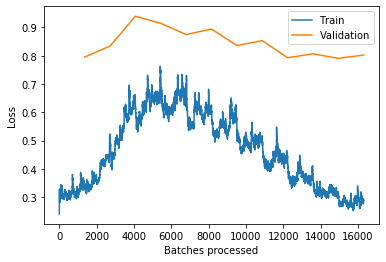

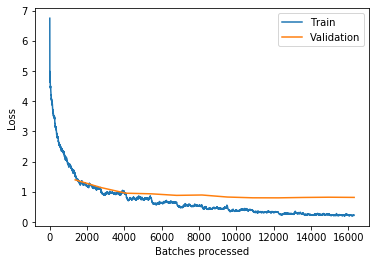

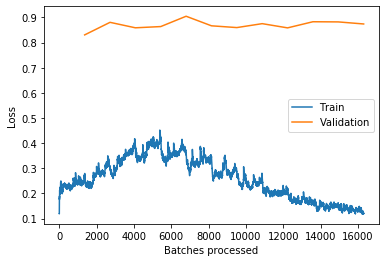

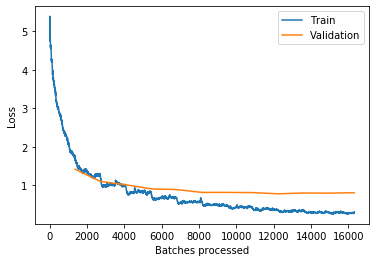

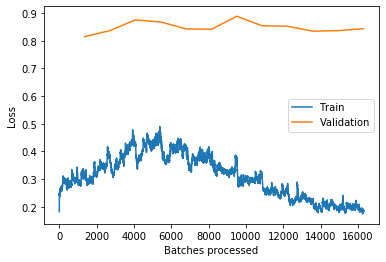

In [46]:
for arch in [[500, 250], [1000, 500], [2000, 1000]]:
    for lr in [3e-3, 1e-3, 1e-4]:
        for emb_drop in [0.04, 0.1]:
            learn = tabular_learner(data, layers=arch, ps=[0.001,0.01], emb_drop=emb_drop, 
                            y_range=y_range, metrics=[root_mean_squared_error, exp_rmspe])
            for wd in [0.2, 0.3]:
                print('architecture', arch)
                print('learning rate', lr)
                print('embedding drop out', emb_drop)
                print('weight decay', wd)
                learn.fit_one_cycle(12, lr, wd=wd)
                learn.recorder.plot_losses()

In [50]:
learn = tabular_learner(data, layers=[2000, 1000], ps=[0.001,0.01], emb_drop=0.04, 
                            y_range=y_range, metrics=[root_mean_squared_error, exp_rmspe])
learn.fit_one_cycle(15, 1e-4, wd=0.4)

epoch,train_loss,valid_loss,root_mean_squared_error,exp_rmspe,time
0,1.591841,1.434826,1.173238,519.499756,00:11
1,1.170884,1.082758,1.014129,415.305237,00:11
2,0.965960,1.012193,0.984310,420.525879,00:11
3,0.841558,0.956525,0.956899,605.834229,00:11
4,0.714017,0.903152,0.930042,248.955246,00:11
5,0.600824,0.848523,0.899247,231.286926,00:11
6,0.527238,0.884171,0.913621,289.229126,00:11
7,0.486411,0.845648,0.889786,446.021820,00:11
8,0.405734,0.824661,0.880954,463.820801,00:11
9,0.372762,0.830904,0.884134,292.072815,00:10


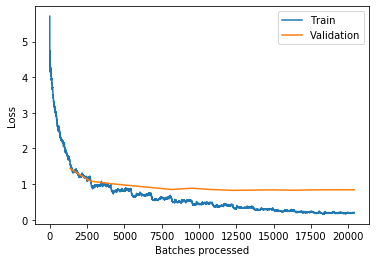

In [53]:
learn.recorder.plot_losses()

In [54]:
learn.save('first')

In [55]:
learn.load('first');

In [56]:
for i in range(100):
    r = df.iloc[range_start + i]
    price = r.price
    prediction = np.exp(learn.predict(r)[1].data[0].item())
    print(f'{price: <10} {prediction: <30}')

2797.2     1126.3656823202182            
4450.0     2560.9365714410364            
10530.0    7673.221281721086             
17495.52   10481.820469093538            
1337.74    1125.2335225333181            
5420.1     3883.218331433377             
11663.34   10354.606847740673            
12120.93   10417.343900647142            
7233.12    5450.643325783647             
35998.92   38236.83816857289             
1130.26    10664.251878342593            
34378.95   9059.709122032018             
9535.78    11621.409077683611            
5296.91    5800.48111585648              
1051.2     3561.8887343037495            
2783.61    1457.487187801095             
16685.03   6688.076726029174             
3839.1     5415.844188351831             
1497.64    3221.202062034214             
925.52     3459.0766936558052            
11286.0    15273.373697450386            
1270.75    3683.1899875824965            
2541.5     2507.0112850867536            
2541.5     2614.5739297597665     